In [2]:
import pickle
from datetime import datetime
from pprint import pprint

import pandas as pd
import numpy as np
import scipy as sp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import ensemble
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import GridSearchCV


import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Read in data
all_data_preprocessed_pkl = open("104K_data_preprocessed.pkl","rb")
all_data = pickle.load(all_data_preprocessed_pkl)
all_data[['call','ex_tag']] = all_data[['call','ex_tag']].astype('int')

all_data[:3]

,id,call,ex_tag,txt
0,CTRL000000096,0,0,subject fw quality moves to utilize on your ...
1,CTRL000000097,0,0,subject schedule confirmation from guzman m...
2,CTRL000000099,0,0,subject emergency meeting from williams iii...


## 1. Benchmark model
(1) Bag-of-Word model: frequency count version

(2) No tf-idf transformation

(3) Default RandomForest classifier

#### 1.1 Apply CountVectorizer with random choice of parameters
Note: vectorized on the whole document space (train + test) to avoid different feature extraction

In [4]:
# Vectorization - count, random choice of parameters
# timing
start_time = datetime.today()

# Instantiate CountVectorizer
vectorizer = CountVectorizer(
                             encoding='utf-8-sig',
                             max_features = 2000,
                             ngram_range = (1, 2),
                             stop_words = 'english',
                             max_df= .95,
                             )
vectorizer.fit(all_data['txt'])
txt_BOW = vectorizer.transform(all_data['txt'])

print (datetime.today() - start_time)
# ~0:50 for (binary) uni-gram
# 3:37 for tri-gram



# See what's it like
print (txt_BOW.shape)
type(txt_BOW)

0:02:07.877604
(104541, 2000)


scipy.sparse.csr.csr_matrix

#### 1.2 Split training and test set
660 training doc; 330/330

In [5]:
# Get doc id for training set
train_docid = []
f_train_docid = open("train_id.txt","r")
for line in f_train_docid:
    file_name = line.lstrip().rstrip()
    train_docid.append(file_name)
f_train_docid.close()

# See what's inside
print(len(set(train_docid)))  # Check uniqueness
print(train_docid[:3])

train_mask = np.where([i in train_docid for i in all_data['id']])[0]
test_mask = np.where([i not in train_docid for i in all_data['id']])[0]

660
['CTRL000052948', 'CTRL000053534', 'CTRL000054613']


In [6]:
X_train = txt_BOW[train_mask,:]
X_test = txt_BOW[test_mask,]
Y_train = all_data.iloc[train_mask,]['call']
Y_test =  all_data.iloc[test_mask,]['call']

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(660, 2000)
(103881, 2000)
(660,)
(103881,)


#### 1.3 Predict with a default RandomForest classifier

In [7]:
# Initiate a classifier
rf_default = ensemble.RandomForestClassifier(random_state = 1)

# Train
rf_default.fit(X_train,Y_train)

# Predict
pred_rf_default = rf_default.predict(X_test)

In [8]:
print ("Prediction - baseline")
print (metrics.confusion_matrix(Y_test, pred_rf_default, labels = [1, 0]))
print ()

accuracy = (metrics.accuracy_score(Y_test, pred_rf_default))
precision = (metrics.precision_score(Y_test, pred_rf_default, pos_label = 1, average = 'binary'))
recall = (metrics.recall_score(Y_test, pred_rf_default, pos_label = 1, average = 'binary'))
f1 = recall = (metrics.f1_score(Y_test, pred_rf_default, pos_label = 1, average = 'binary'))
print ("Accuracy: %f;\n Precision: %f;\n Recall: %f;\n f1 score: %f" %(accuracy, precision, recall, f1))

Prediction - baseline
[[ 1030 13957]
 [  628 88266]]

Accuracy: 0.859599;
 Precision: 0.621230;
 Recall: 0.123761;
 f1 score: 0.123761


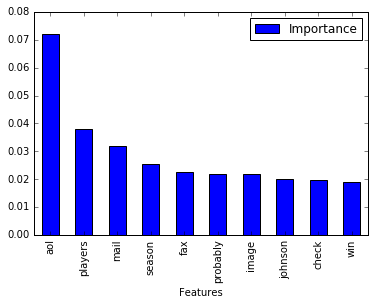

In [9]:
feature_df = pd.DataFrame({"Features": vectorizer.get_feature_names(), 
                           "Importance": rf_default.feature_importances_
                          })
feature_df.sort_values('Importance', ascending = False)[:10].plot(x = 'Features', y = 'Importance', kind='bar')

### 2. Optimize vectorizing process
(1) Optimize parameters for CountVectorizer

(2) Apply and optimize parameters for tf-idf transformation

(3) Optimizae parameters for RandomForest classifier

In [9]:
# Parameters
N_CORES = 1  
CV_FOLDS = ShuffleSplit(all_data.shape[0], random_state = 1, n_iter = 10, test_size = 0.95)

#### 2.1 Optimize parameters for CountVectorizer

In [10]:
# Create a pipeline: bag-of-word vectorizer -> default RandomForest classifier
pipeline = Pipeline ([
        ('vect_bow', CountVectorizer(encoding = 'utf-8-sig', stop_words = 'english', ngram_range = (1, 1))),
        ('model_rf', ensemble.RandomForestClassifier(random_state = 1))
    ])


# Find best combination of number of features and range of n-gram
parameters_1 = {
    'vect_bow__binary': (False, True),
    'vect_bow__max_features': (200, 2000, 5000),
    'vect_bow__max_df': (0.95, 0.85)
}


# choose the best parameter combo to max f1 score
grid_search_1 = GridSearchCV(pipeline, parameters_1, cv = CV_FOLDS, scoring = 'f1', n_jobs = N_CORES)  

# scoring params:
# precision
# recall
# roc_auc (<=> precision)
# f1 - harmonic mean of precision and recall

In [11]:
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters_1)
start_time = datetime.today() 
grid_search_1.fit(all_data['txt'], all_data['call'])
print(datetime.today() - start_time)
print()

print(grid_search_1.best_score_)
print(grid_search_1.best_params_)
pprint(grid_search_1.grid_scores_)

pipeline: ['vect_bow', 'model_rf']
parameters:
{'vect_bow__max_df': (0.95, 0.85), 'vect_bow__binary': (False, True), 'vect_bow__max_features': (200, 2000, 5000)}
0:46:27.187297

0.935400759542
{'vect_bow__max_df': 0.95, 'vect_bow__binary': True, 'vect_bow__max_features': 5000}
[mean: 0.90890, std: 0.00371, params: {'vect_bow__max_df': 0.95, 'vect_bow__binary': False, 'vect_bow__max_features': 200},
 mean: 0.92454, std: 0.00390, params: {'vect_bow__max_df': 0.95, 'vect_bow__binary': False, 'vect_bow__max_features': 2000},
 mean: 0.93154, std: 0.00303, params: {'vect_bow__max_df': 0.95, 'vect_bow__binary': False, 'vect_bow__max_features': 5000},
 mean: 0.90890, std: 0.00371, params: {'vect_bow__max_df': 0.85, 'vect_bow__binary': False, 'vect_bow__max_features': 200},
 mean: 0.92454, std: 0.00390, params: {'vect_bow__max_df': 0.85, 'vect_bow__binary': False, 'vect_bow__max_features': 2000},
 mean: 0.93154, std: 0.00303, params: {'vect_bow__max_df': 0.85, 'vect_bow__binary': False, 'vect_b

In [14]:
{'vect_bow__max_df': 0.95, 'vect_bow__binary': True, 'vect_bow__max_features': 5000}

# Keep best parameters
BINARY_1 = grid_search_1.best_params_['vect_bow__binary']
MAX_FEATURES_1 = grid_search_1.best_params_['vect_bow__max_features']
MAX_DF_1 = grid_search_1.best_params_['vect_bow__max_df']

# Keep best parameters for count frequency
BINARY_2 = False
MAX_FEATURES_2 = 5000
MAX_DF_2 = 0.85

#### 2.2 Apply and optimize parameters for tf-idf transformation

In [16]:
pipeline_2 = Pipeline([
        ('vect_bow', CountVectorizer(encoding = 'utf-8-sig', 
                                     stop_words = 'english', 
                                     binary = BINARY_2,
                                     max_df = MAX_DF_2, 
                                     max_features = MAX_FEATURES_2,
                                     ngram_range = (1, 1))), # Use optimized feature just now
        ('tfidf', TfidfTransformer()),
        ('model_rf', ensemble.RandomForestClassifier(random_state = 1))
    ])

parameters_2 = {
    'tfidf__use_idf': (False, True),
    'tfidf__norm': ('l2', 'l1', None),
    'tfidf__sublinear_tf': (False, True),
}

grid_search_2 = GridSearchCV(pipeline_2, parameters_2, cv = CV_FOLDS, scoring = 'f1', n_jobs = N_CORES) 


In [17]:
print("pipeline:", [name for name, _ in pipeline_2.steps])
print("parameters:")
print(parameters_2)
start_time = datetime.today()
grid_search_2.fit(all_data['txt'], all_data['call'])
print()

print(datetime.today() - start_time)
print()

print(grid_search_2.best_score_)
print(grid_search_2.best_params_)
print()

pprint(grid_search_2.grid_scores_)

pipeline: ['vect_bow', 'tfidf', 'model_rf']
parameters:
{'tfidf__norm': ('l2', 'l1', None), 'tfidf__sublinear_tf': (False, True), 'tfidf__use_idf': (False, True)}

0:48:11.530063

0.932189641716
{'tfidf__norm': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': False}

[mean: 0.92943, std: 0.00313, params: {'tfidf__norm': 'l2', 'tfidf__sublinear_tf': False, 'tfidf__use_idf': False},
 mean: 0.92815, std: 0.00306, params: {'tfidf__norm': 'l2', 'tfidf__sublinear_tf': False, 'tfidf__use_idf': True},
 mean: 0.92996, std: 0.00251, params: {'tfidf__norm': 'l2', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': False},
 mean: 0.92919, std: 0.00208, params: {'tfidf__norm': 'l2', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True},
 mean: 0.92911, std: 0.00261, params: {'tfidf__norm': 'l1', 'tfidf__sublinear_tf': False, 'tfidf__use_idf': False},
 mean: 0.92798, std: 0.00313, params: {'tfidf__norm': 'l1', 'tfidf__sublinear_tf': False, 'tfidf__use_idf': True},
 mean: 0.92891, std: 0.00312, params:

In [18]:
# Keep best parameters
SUBLINEAR_TF = grid_search_2.best_params_['tfidf__sublinear_tf']
USE_IDF = grid_search_2.best_params_['tfidf__use_idf']
NORM = grid_search_2.best_params_['tfidf__norm']

#### 2.3 Optimize parameters for Randomforest

In [19]:
# Apply optimized transformation

# timing
start_time = datetime.today()

# 1. Vectorize to count matrix
vectorizer = CountVectorizer(
                             encoding = 'utf-8-sig', 
                             stop_words = 'english', 
                             binary = BINARY,
                             max_df = MAX_DF, 
                             max_features = MAX_FEATURES, 
                             ngram_range = (1, 1)
                             )
vectorizer.fit(all_data['txt'])
txt_BOW = vectorizer.transform(all_data['txt'])



# 2. Tf-idf transformation
tfidf_transformer = TfidfTransformer(
                                     sublinear_tf = SUBLINEAR_TF, 
                                     use_idf = USE_IDF, 
                                     norm = NORM)
tfidf_transformer.fit(txt_BOW)
txt_TFIDF = tfidf_transformer.transform(txt_BOW)

# timing
print (datetime.today() - start_time)

# See what's it like
print (txt_TFIDF.shape)

0:00:45.838000
(104541, 5000)


In [20]:
model_rf = ensemble.RandomForestClassifier(random_state = 1, n_jobs = N_CORES)

parameters_rf = {
    'n_estimators': (100, 200, 300),
    'max_features': ('log2', 40, 'sqrt'),
    'min_samples_leaf': (1, 10, 50)
    
    # 3 major attributes that affect a RF performance/processing time
}

grid_search_rf = GridSearchCV(model_rf, parameters_rf, cv = CV_FOLDS, scoring = 'f1')

In [21]:
start_time = datetime.today()
grid_search_rf.fit(txt_TFIDF, all_data['call'])

print(datetime.today() - start_time)
print()

print(grid_search_rf.best_score_)
print(grid_search_rf.best_params_)
print()

pprint(grid_search_rf.grid_scores_)

C:\Users\Yuwen Wang\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Yuwen Wang\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Yuwen Wang\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Yuwen Wang\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Yuwen Wang\Anaconda3\lib\site-packages\sklearn\metrics\classifi

0:26:00.422392

0.939223980736
{'max_features': 'sqrt', 'n_estimators': 200, 'min_samples_leaf': 1}

[mean: 0.93076, std: 0.00217, params: {'max_features': 'log2', 'n_estimators': 100, 'min_samples_leaf': 1},
 mean: 0.93181, std: 0.00211, params: {'max_features': 'log2', 'n_estimators': 200, 'min_samples_leaf': 1},
 mean: 0.93203, std: 0.00221, params: {'max_features': 'log2', 'n_estimators': 300, 'min_samples_leaf': 1},
 mean: 0.02294, std: 0.01851, params: {'max_features': 'log2', 'n_estimators': 100, 'min_samples_leaf': 10},
 mean: 0.03039, std: 0.01934, params: {'max_features': 'log2', 'n_estimators': 200, 'min_samples_leaf': 10},
 mean: 0.03493, std: 0.01884, params: {'max_features': 'log2', 'n_estimators': 300, 'min_samples_leaf': 10},
 mean: 0.00000, std: 0.00000, params: {'max_features': 'log2', 'n_estimators': 100, 'min_samples_leaf': 50},
 mean: 0.00000, std: 0.00000, params: {'max_features': 'log2', 'n_estimators': 200, 'min_samples_leaf': 50},
 mean: 0.00000, std: 0.00000, 

In [22]:
# Keep best params
N_ESTIMATORS = grid_search_rf.best_params_['n_estimators']
MIN_SAMPLES_LEAF = grid_search_rf.best_params_['min_samples_leaf']
MAX_FEATURES_RF = grid_search_rf.best_params_['max_features']

In [27]:
# Keep best parameters for count frequency
BINARY_2 = False
MAX_FEATURES_2 = 5000
MAX_DF_2 = 0.85
'tfidf__norm': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': False
N_ESTIMATORS = 200
MIN_SAMPLES_LEAF = 1
MAX_FEATURES = 'sqrt'

200

### 3. Apply optimized vectorizing and RandomForestClassifier

In [23]:
X_train = txt_TFIDF[train_mask,:]
X_test = txt_TFIDF[test_mask,]
Y_train = all_data.iloc[train_mask,]['call']
Y_test =  all_data.iloc[test_mask,]['call']

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(660, 5000)
(103881, 5000)
(660,)
(103881,)


In [24]:
rf_optimized = ensemble.RandomForestClassifier(
                                               random_state = 1, 
                                               n_jobs = N_CORES,
                                               n_estimators = N_ESTIMATORS,
                                               min_samples_leaf = MIN_SAMPLES_LEAF,
                                               max_features = MAX_FEATURES_RF
                                               )
rf_optimized.fit(X_train, Y_train)
pred_rf_optimized = rf_optimized.predict(X_test)

In [25]:
print ("Prediction - optimized")
print (metrics.confusion_matrix(Y_test, pred_rf_optimized, labels = [1, 0]))

accuracy = (metrics.accuracy_score(Y_test, pred_rf_optimized))
precision = (metrics.precision_score(Y_test, pred_rf_optimized, pos_label = 1, average = 'binary'))
recall = (metrics.recall_score(Y_test, pred_rf_optimized, pos_label = 1, average = 'binary'))
f1 = (metrics.f1_score(Y_test, pred_rf_optimized, pos_label = 1, average = 'binary'))
print ("Accuracy: %f;\n Precision: %f;\n Recall: %f;\n f1 score: %f" %(accuracy, precision, recall, f1))

Prediction - optimized
[[ 1032 13955]
 [  334 88560]]
Accuracy: 0.862448;
 Precision: 0.755490;
 Recall: 0.126215;
 f1 score: 0.126215


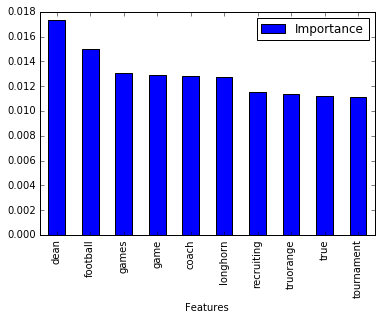

In [26]:
feature_df = pd.DataFrame({"Features": vectorizer.get_feature_names(), 
                           "Importance": rf_optimized.feature_importances_
                          })
feature_df.sort_values('Importance', ascending = False)[:10].plot(x = 'Features', y = 'Importance', kind='bar')